Data shapes → X: (101619, 19), Y: (101619,), Vocab size: 8932
Epoch 1/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.0617 - loss: 6.4829 - val_accuracy: 0.0921 - val_loss: 6.7089
Epoch 2/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.1250 - loss: 5.6342 - val_accuracy: 0.1088 - val_loss: 6.6303
Epoch 3/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.1480 - loss: 5.3814 - val_accuracy: 0.1069 - val_loss: 6.6136
Epoch 4/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 17s 23ms/step - accuracy: 0.1611 - loss: 5.2224 - val_accuracy: 0.1145 - val_loss: 6.5531
Epoch 5/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.1787 - loss: 5.0615 - val_accuracy: 0.1069 - val_loss: 6.6108
Epoch 6/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.1909 - loss: 4.9491 - val_accuracy: 0.1183 - val_loss: 6.6958
Epoch 7/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.2013 - loss: 4.8448 - val_accuracy: 0.1049 - val_loss: 6.7990
Epoch 8/10
755/755 ━━━━━━━━━

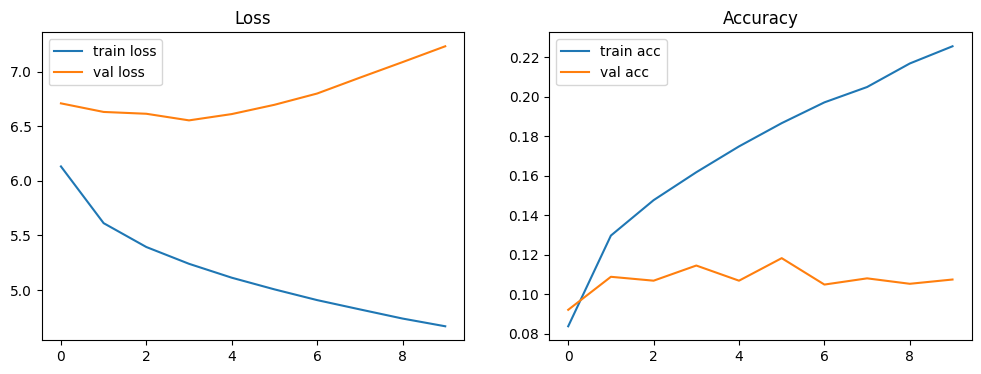


Enter a seed phrase to get predictions. Type 'quit' to exit.

Next word → you
Beam search completions:
  1. how are you ” said
  2. how are you ” he
  3. how are it ” he

Next word → the
Beam search completions:
  1. what is it ” he
  2. what is it ” said
  3. what is the matter of

Next word → on
Beam search completions:
  1.  ’ said he
  2.  ’ said i
  3.  so i have

Next word → on
Beam search completions:
  1.  ’ said he
  2.  ’ said i
  3.  so i have

Next word → on
Beam search completions:
  1.  ’ said he
  2.  ’ said i
  3.  so i have

Next word → on
Beam search completions:
  1.  ’ said he
  2.  ’ said i
  3.  so i have

Next word → on
Beam search completions:
  1.  ’ said he
  2.  ’ said i
  3.  so i have

Next word → on
Beam search completions:
  1.  ’ said he
  2.  ’ said i
  3.  so i have

Next word → on
Beam search completions:
  1.  ’ said he
  2.  ’ said i
  3.  so i have



KeyboardInterrupt: Interrupted by user

In [3]:


import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import heapq
import pickle
import matplotlib.pyplot as plt

# ─── 2. LOAD & PREPROCESS ─────────────────────────────────────────────────────
with open('text.txt', 'r', encoding='utf-8') as f:
    text = f.read().lower()

# Split into non-empty lines
lines = [line.strip() for line in text.split('\n') if line.strip()]

# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
total_words = len(tokenizer.word_index) + 1

# Build n‑gram sequences
input_sequences = []
for line in lines:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram = token_list[:i+1]
        input_sequences.append(n_gram)

# Pad sequences
max_seq_len = max(len(seq) for seq in input_sequences)
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

# Split into X and Y
X = input_sequences[:, :-1]
Y = input_sequences[:, -1].reshape(-1)
print(f"Data shapes → X: {X.shape}, Y: {Y.shape}, Vocab size: {total_words}")

# ─── 3. BUILD & TRAIN MODEL ────────────────────────────────────────────────────
model = Sequential([
    Embedding(input_dim=total_words, output_dim=64, input_length=max_seq_len-1),
    LSTM(100),
    Dense(total_words, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.01),
    metrics=['accuracy']
)
history = model.fit(X, Y, epochs=10, batch_size=128, validation_split=0.05)

# ─── 4. PLOT TRAINING METRICS ──────────────────────────────────────────────────
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

# ─── 5. SAVE MODEL & TOKENIZER ─────────────────────────────────────────────────
model.save('next_word_model.h5')
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# ─── 6. INFERENCE UTILITIES ────────────────────────────────────────────────────
def predict_next_word(seed_text):
    """Return the single most likely next word."""
    seq = tokenizer.texts_to_sequences([seed_text])[0]
    seq = pad_sequences([seq], maxlen=max_seq_len-1, padding='pre')
    preds = model.predict(seq, verbose=0)[0]
    next_idx = np.argmax(preds)
    return tokenizer.index_word.get(next_idx, '')

def beam_search_predict(seed_text, beam_width=3, next_words=5):
    """Return the top `beam_width` sequences of length `next_words`."""
    sequences = [(seed_text, 0.0)]
    for _ in range(next_words):
        all_cands = []
        for sent, score in sequences:
            token_seq = tokenizer.texts_to_sequences([sent])[0]
            token_seq = pad_sequences([token_seq], maxlen=max_seq_len-1, padding='pre')
            preds = model.predict(token_seq, verbose=0)[0]
            top_idxs = np.argsort(preds)[-beam_width:]
            for idx in top_idxs:
                word = tokenizer.index_word.get(idx, '')
                cand = sent + ' ' + word
                cand_score = score - np.log(preds[idx] + 1e-10)
                all_cands.append((cand, cand_score))
        sequences = heapq.nsmallest(beam_width, all_cands, key=lambda x: x[1])
    return [s for s, _ in sequences]

# ─── 7. INTERACTIVE LOOP ───────────────────────────────────────────────────────
print("\nEnter a seed phrase to get predictions. Type 'quit' to exit.\n")

while True:
    seed = input("You: ")
    if seed.lower() in ('quit', 'exit'):
        print("Goodbye!")
        break

    next_word = predict_next_word(seed)
    print(f"Next word → {next_word}")

    beam_results = beam_search_predict(seed, beam_width=3, next_words=3)
    print("Beam search completions:")
    for i, seq in enumerate(beam_results, 1):
        print(f"  {i}. {seq}")
    print()
